# Tutorial Two: creating an experimental object 

## Introduction 

The working engines of IPTK are the classes Experiment, introduced in this tutorial, and ExperimentalSet, introduced in the next tutorial. The experimental object acts as an anchor point connecting the identified peptides with the expression value of their parent transcript, with the proband metadata and with the HLA allele(s) from which peptides were eluted. We start the tutorial by preparing the input to the class constructor, then we create an experimental object and, finally, we use the class API, along with analysis and visualization module, to demonstrate different analysis methods enabled by the library. 

## Background

 The dataset was obtained from the [HLA-Ligand Atlas](https://hla-ligand-atlas.org/hlas). The data represents the 
small intestine immunopeptidome of patient, AUT01-DN03.   

#### Note

 - The data used in this tutorial is available at the current working directory in the data folder. I mean, the code here assumes that the current working directory is set to Tutorials. 

In [2]:
## Make sure the library is installed and installing it if it is not installed.  
try: 
    import IPTK 
except ModuleNotFoundError: 
    import os
    os.system("pip install iptkl --user")

## Loading the module

In [25]:
from IPTK.Classes.Experiment import Experiment
from IPTK.Classes.Database import SeqDB, GeneExpressionDB, CellularLocationDB,OrganismDB
from IPTK.Classes.Tissue import Tissue
from IPTK.Classes.HLASet import HLASet
from IPTK.Classes.Proband import Proband
from IPTK.Classes.Peptide import Peptide 
from IPTK.IO.InFunctions import parse_text_table, download_pdb_entry
from IPTK.IO.OutFunctions import write_auto_named_peptide_to_fasta   
from IPTK.Visualization.vizTools import (plot_peptide_length_dist, plot_num_peptides_per_organism, plot_num_peptides_per_parent, plot_parent_protein_expression_in_tissue, plot_gene_expression_vs_num_peptides, plot_num_protein_per_location, plot_num_peptide_per_go_term,
plot_protein_coverage, imposed_coverage_on_3D_structure,plotly_peptide_length_dist)
from IPTK.Analysis.AnalysisFunction import get_sequence_motif, compute_binary_distance
from IPTK.IO.OutFunctions import write_auto_named_peptide_to_fasta
from IPTK.Utils.Mapping import map_from_uniprot_pdb
import matplotlib.pyplot as plt
from typing import List,Set,Dict 
import pandas as pd 
import numpy as np
import random 
## install chart_studio if not installed, needed for working with plotly graph 
try: 
    import chart_studio.plotly as py 
except ModuleNotFoundError:
    os.system("pip install chart_studio")

## Load the identification table

#### Notes: 
- As we do not have access to the exact FASTA file used for generating the peptides we are using the whole Uniprot database, i.e. uniprot_sprot.fasta, to extract sequences from the database. Unfortunately, this file is about 266MB and could not be uploaded to Github. So, users are encouraged to download this file from Uniprot websites. To follow along, kindly, download the data from:  https://www.uniprot.org/downloads and select Swiss-Prot in a Fasta format. 

 - The database is used to extract the sequence of the parent proteins. These sequences are used heavily in the library, for example, to obtain the flanking region, to generate the mapping tensors, and to compute and visualize the coverage.  
  - For Ipython user, please use the magic command %matplotlib to work interactively with visualization. 
 

In [9]:
## Note: 
Path2Database='/Users/heshamelabd/databases/uniprot_sprot.fasta' ## update this path to your own local path. 
table: pd.DataFrame = parse_text_table(path2file='data/AUT01-DN03_Small_intestine.csv',
                     path2fastaDB=Path2Database, # reference to extract the start and end index. 
                    seq_column="peptide_seq",
                    accession_column="protein_names")

### Create the objects needed to build the experimental object 

In [11]:
proband: Proband = Proband(name='AUT01-DN03')  # the name of the proband 
hla_set: HLASet = HLASet(hlas=['HLA-DRB1*15:01']) # just a place holder to represent the HLA allele, an instance of class HLASet
seqs: SeqDB = SeqDB(path2fasta=Path2Database) # the path to load the sequence database, SAME, as defined above for loading the tables 
expresson_profile: GeneExpressionDB= GeneExpressionDB() # use the data on the human protein atlas @https://www.proteinatlas.org/about/download --> Normal tissue data 
protein_locations: CellularLocationDB= CellularLocationDB() # use the data on the human protein atlas @https://www.proteinatlas.org/about/download --> Subcellular location data
tissue: Tissue = Tissue(name='small intestine',
                        main_exp_value=expresson_profile, 
                        main_location=protein_locations) # create the tissue instance 

#### Note

The class HLASet will throw a Runtime error if any of the provided alleles does not have a valid name. An example is shown below: 

In [12]:
try: 
    HLASet(hlas=['HL15:01l'])
except RuntimeError as exp:
    print(f'The exception was: \n {exp}')

The exception was: 
 While adding the allele: HL15:01l to the set, the following error : while parsing the chain named: HL15:01l The following error was encountered: The suffix 'l' of 'HL15:01l' was not parsed was encountered.


The same can happen with the wrong/unsupported tissue name, which might will cause a KeyError exception as shown in the example below.

In [16]:
try:
    Tissue(name='SMALL intestine',
    main_exp_value=expresson_profile, 
    main_location=protein_locations)
except KeyError as exp:
    print(f'The exception was: \n {exp}')

The exception was: 
 'The provided tissue name: SMALL intestine is not in the provided main expression database'


## Construct the experiment 

In [17]:
exp = Experiment(proband=proband,hla_set=hla_set,tissue=tissue,database=seqs, 
                 ident_table=table)

In [18]:
print(exp)

an experiment from proband: AUT01-DN03, tissue: small intestine,
				   with an HLA Class: 2. The instances contains 
				   3167 peptides identified from 810 proteins.


## Navigating the experiment API 

### Plot peptide length distribution 

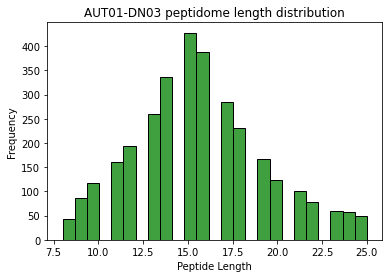

In [27]:
peptide_length: List[int] = exp.get_peptides_length()
# plot the length distribution
fig=plot_peptide_length_dist(peptide_length,{'color':'green'},
                             title='AUT01-DN03 peptidome length distribution') 

### Using Plotly to visualize peptide length distribution

In [29]:
# Note: we just change plot --> plotly to use plotly
fig=plotly_peptide_length_dist(peptide_length,
                             title='AUT01-DN03 peptidome length distribution') 
py.iplot(fig, filename = 'AUT01-DN03 peptidome length distribution')
## This enable us to have a more interactive visualization of the results 

### The number of peptides per protein 

In [20]:
num_per_protein: pd.DataFrame = exp.get_peptides_per_protein() 
# show the first 10 elements 
num_per_protein.head(10)

,Proteins,Number_of_Peptides
266,Q9Y6R7,115
223,P04114,93
17,P68871,56
24,P69905,41
756,P68032,37
13,P62736,37
154,P04406,37
502,P63267,31
198,P61769,31
63,P02751,30


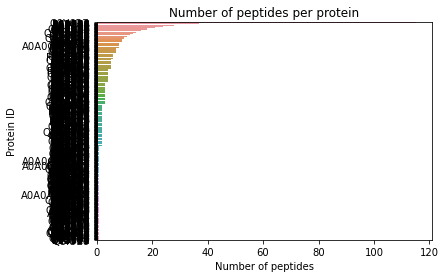

In [9]:
# we can visualize the number of peptides per protein 
fig=plot_num_peptides_per_parent(num_per_protein)      

As seen above, the figures y-axis is crowded and we can not see the distribution clearly. To overcome this, we can set hide_y_label to True to get a clearer version of the function 

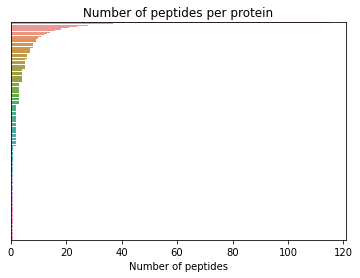

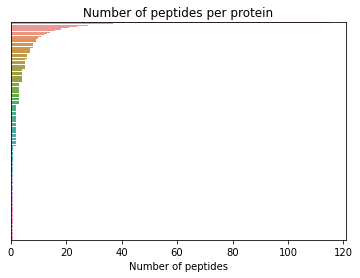

In [33]:
fig=plot_num_peptides_per_parent(nums_table=num_per_protein, hide_y_label=True)

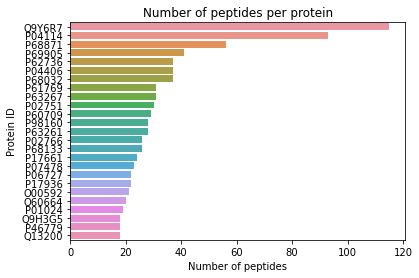

In [10]:
# we can also focus in the first-top 25 proteins to get a clearer picture 
fig=plot_num_peptides_per_parent(num_per_protein,25)

### The gene expression of the parent proteins 

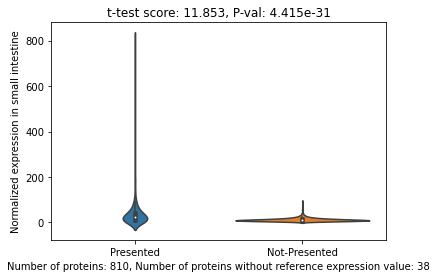

In [35]:
parent_protein_exp: pd.DataFrame = exp.get_expression_of_parent_proteins() # get the expression table of the parent proteins. 
# Incase the expression of a protein could not be estimated, the function returns a default value of # -1. This is used as a filteration criteria to filter the results, where, for examples, here, these # peptides are not considered in the analysis. 
reference_gene_expression: pd.DataFrame = exp.get_experiment_reference_tissue_expression() # compute the reference gene expression 
fig=plot_parent_protein_expression_in_tissue(parent_protein_exp,reference_gene_expression, 
                                             tissue_name=exp.get_tissue_name(),
                                            ylabel='Normalized expression') # plot the results 

### Plot the correlation between the gene expression and number of peptides observed

The number of genes without a reference expression is: 38


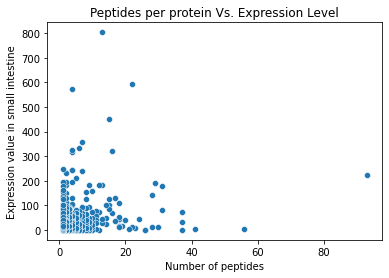

In [38]:
# get the number of peptides per parent protein 
num_peptides_parent: pd.DataFrame = exp.get_num_peptide_expression_table() 
# print the number of un-mapped genes 
#***********************
## Note: Genes proteins missing gene expression values have a default value of -1
#***********************
print(f'The number of genes without a reference expression is: {num_peptides_parent.loc[num_peptides_parent.iloc[:,-1]==-1].shape[0]}')
# plot the gene expression vs. number of peptides 
fig=plot_gene_expression_vs_num_peptides(num_peptides_parent,tissue_name=exp.get_tissue_name())

### Get the location of the parent proteins

In [13]:
# get the source protein 
parent_protein_source_loc: pd.DataFrame = exp.get_main_sub_cellular_location_of_parent_proteins()
# show the head of the table  
print(parent_protein_source_loc.head(10))
print(parent_protein_source_loc.shape)

  Proteins Main_locations
0   P02656    Nucleoplasm
1   O75348       Nucleoli
2   Q9H4G4       Vesicles
3   Q06828            UNK
4   O75306   Mitochondria
5   Q6W3E5            UNK
6   P11021        Cytosol
7   P28062       Vesicles
8   Q9BSH5       Nucleoli
9   Q6L8Q7            UNK
(810, 2)


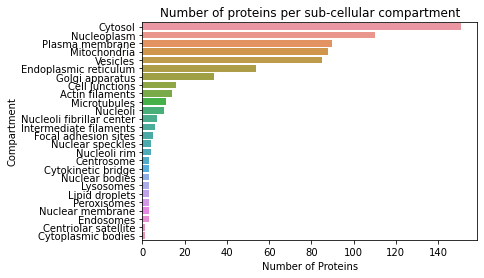

In [14]:
# get the number of proteins in each location 
protein_counts: pd.DataFrame = exp.get_number_of_proteins_per_compartment() 
# plot the number of proteins per-location
fig=plot_num_protein_per_location(protein_counts,drop_unknown=True) 

#### Get the gene ontology (GO) of the parent proteins 

In [15]:
# get the GO of the source protein 
parent_protein_go_id: pd.DataFrame = exp.get_go_location_id_parent_proteins()
# show the head of the table  
##************************ 
# Note: Incase the Gene-ontology for a protein is not knonw. The function returns, UNK as a default # value.   
##************************
print(parent_protein_go_id.head(10))

  Proteins                                           GO_Terms
0   P02656  Cell Junctions (GO:0030054);Nucleoli (GO:00057...
1   O75348     Nucleoli (GO:0005730);Nucleoplasm (GO:0005654)
2   Q9H4G4    Microtubules (GO:0015630);Vesicles (GO:0043231)
3   Q06828                                                UNK
4   O75306                          Mitochondria (GO:0005739)
5   Q6W3E5                                                UNK
6   P11021                               Cytosol (GO:0005829)
7   P28062  Cytokinetic bridge (GO:0045171);Vesicles (GO:0...
8   Q9BSH5        Nucleoli (GO:0005730);Vesicles (GO:0043231)
9   Q6L8Q7                                                UNK


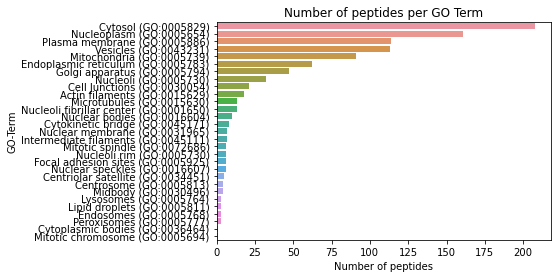

In [16]:
# get the number of proteind in each location 
protein_counts: pd.DataFrame = exp.get_number_of_proteins_per_go_term()
# plot the number of proteins per-location
fig=plot_num_peptide_per_go_term(protein_counts,drop_unknown=True) 

### plot the number of peptides per Location

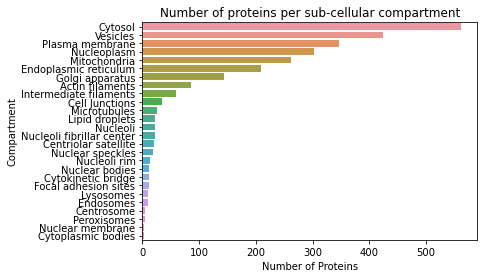

In [17]:
fig=plot_num_protein_per_location(exp.get_num_peptide_per_location(), drop_unknown=True)


### plot the number of peptides per GO-Term

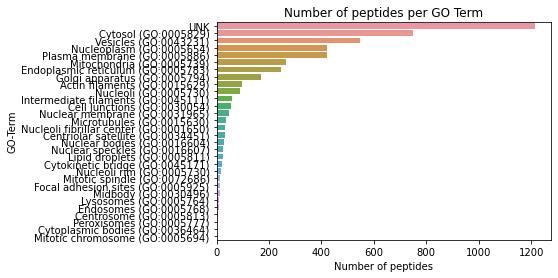

In [18]:
fig=plot_num_peptide_per_go_term(exp.get_num_peptide_per_go_term())

## Work with Peptide object

### Getting the unique, i.e. peptides with only 1 parent protein, peptides in the database 

In [18]:
mono_parental_peptides: List[Peptide] = exp.get_mono_parent_peptides()
print(f'Number of peptides that were observed in only one protein: {len(mono_parental_peptides)}')
# print the sequnce of the first 10 peptides 
print('Print the first 10 peptide in the list of unique peptides: ')
for idx in range(10):
    print('\t'+str(mono_parental_peptides[idx]))

Number of peptides that were observed in only one protein: 3167
Print the first 10 peptide in the list of unique peptides: 
	EIVKEVSTYIKKIGYNPDT
	KPSERHVFIVDDFESF
	AKIIRHPKYNSRTLD
	IEGVDAEDGHGPGEQQ
	ITILGTVKPNANRIALD
	TADGIVSHLKKQAGPAS
	AYIPTNVISITD
	IALDDAKINFNEKLSQLQT
	TADGIVSHLKKQAGPASVP
	VVAVGAEYYLESLNKDKKHH


### Getting the peptides with Their flanking region from every parent protein

In [19]:
flanking_region: List[str] = exp.get_flanked_peptides(flank_length=8)
# print the the first 10 sequences 
print(f'The first 10 peptides including their flanking region:')
for idx in range(10):
    print(flanking_region[idx])

The first 10 peptides including their flanking region:
PYSQKRYEEIVKEVSTYIKKIGYNPDTVAFVPISG
NELANIASKPSERHVFIVDDFESFEKIEDNLI
GNEQFINAAKIIRHPKYNSRTLDNDILLIKL
FLSSLTETIEGVDAEDGHGPGEQQKRKIVLDP
GGVVPRMLITILGTVKPNANRIALDFQRGNDVA
AGAYDGPRTADGIVSHLKKQAGPASVPLRTEEE
ETQAGDVSAYIPTNVISITDGQIFLETE
RITENDIQIALDDAKINFNEKLSQLQTYMIQFDQY
AGAYDGPRTADGIVSHLKKQAGPASVPLRTEEEFK
FKWGFAAFVVAVGAEYYLESLNKDKKHH


## Writing the generated sequences to a FASTA file 


In [20]:
write_auto_named_peptide_to_fasta(flanking_region, 'Tutorial2_flanked_regions.fasta')

### Analyzing the C-terminal sequences 

In [22]:
c_terminal_sequence: List[str] = exp.get_c_terminal_flanked_seqs(8)
# drop shorter sequences -> peptide at the end of the protein. 
c_terminal_sequence = [elem for elem in c_terminal_sequence if len(elem) == 8]
# print the top 10 sequence
for idx in range(10):
    print(c_terminal_sequence[idx])

VAFVPISG
EKIEDNLI
NDILLIKL
KRKIVLDP
FQRGNDVA
VPLRTEEE
GQIFLETE
YMIQFDQY
LRTEEEFK
AQLIWSRA


In [21]:
n_terminal_sequence: List[str] = exp.get_n_terminal_flanked_seqs(8)
# drop shorter seq -> peptide at the begging of the protein. 
n_terminal_sequence = [elem for elem in n_terminal_sequence if len(elem) == 8]
# print the top 10 sequence
for idx in range(10):
    print(n_terminal_sequence[idx])

PYSQKRYE
NELANIAS
GNEQFINA
FLSSLTET
GGVVPRML
AGAYDGPR
ETQAGDVS
RITENDIQ
AGAYDGPR
FKWGFAAF


### Get the mapped proteins 

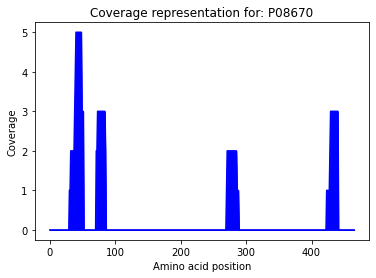

In [25]:
# Compute a tensor of mapped proteins
mapped_proteins: Dict[str,np.ndarray] = exp.get_mapped_proteins()
# Plot the mapping for a randomly selected proteins, protein P08670
fig=plot_protein_coverage(mapped_proteins['P08670'],prot_name=sample_protein,col='blue') 

## 3D structure analysis 

#### Notes
 - Please ignore the warning messages printed by BioPython, they are benging warrning regarding the parsing of the mmCIF file 
  - Second, please run the following code in the web-browser using a Jupyter-notebook, as these cells depend on NGLViewer for visualization.  

### Analyzing P04114 protein 

In [26]:
# get its Protein DataBank ID
protein_id: pd.DataFrame = map_from_uniprot_pdb(uniprots=['P68871'])
print(protein_id)
path_to_file=download_pdb_entry(protein_id.PDB.tolist()[0]) # download and view the first match 
imposed_coverage_on_3D_structure(path2mmCIF=path_to_file, mapped_protein=mapped_proteins['O00560'],
                                low='grey',high='red')

    Uniprot-ID   PDB
0       P68871  1A00
1       P68871  1A01
2       P68871  1A0U
3       P68871  1A0Z
4       P68871  1A3N
..         ...   ...
273     P68871  6LCX
274     P68871  6NBC
275     P68871  6NBD
276     P68871  6NQ5
277     P68871  6TB2

[278 rows x 2 columns]


NGLWidget(background='black')

To learn more please check [Tutorial 3](Tutorial_three_comparing_different_experiments.ipynb)